In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import seaborn as sns

<h2>Load Image</h2>

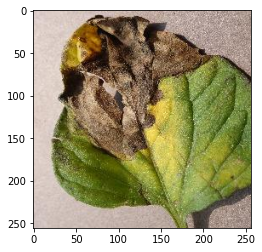

In [9]:
image = cv2.cvtColor(cv2.imread("./test_images/0a4b3cde-c83a-4c83-b037-010369738152___RS_Late.B 6985.JPG"), cv2.COLOR_BGR2RGB)

plt.imshow(image)

<h2> Algorithm to segment out the background </h2>

In [10]:
def segment_background(image):
    '''
    This functions segments out the background given a leaf image.
    
    Inputs:
    image => a numpy array representation of the original image.
    
    Returns:
    seg_image => segmented image mask
    '''
    im = np.copy(image)
    
    hsv = cv2.cvtColor(im, cv2.COLOR_RGB2HSV)
    
    s_max = np.amax(hsv[:, :, 1])
    s_min = np.amin(hsv[:, :, 1])
    
    v_max = np.amax(hsv[:, :, 2])
    v_min = np.amin(hsv[:, :, 2])
    
    hsv = hsv.reshape(-1, 3)
  
    for idx, pixel in enumerate(hsv):
        h, s, v = pixel
        norm_s  = (s - s_min) / (s_max - s_min)
        norm_v = (v - v_min) / (v_max - v_min)
        
        if norm_s > 0.1 and norm_s < 0.5:
            s = (0.7 * (s_max - s_min)) + s_min
        
        if norm_v > 0.6:
            v = (0.4 * (v_max - v_min)) + v_min
        
        hsv[idx] = np.array([h, s, v], dtype = np.uint8)
    
    hsv = hsv.reshape(im.shape)
    
    im = cv2.cvtColor(hsv, cv2.COLOR_HSV2RGB)
    #max red
    max_r = np.amax(im[:, :, 0])
        
    #max green
    max_g = np.amax(im[:, :, 1])
    
    #max blue
    max_b = np.amax(im[:, :, 2])
    
    #calculating normalized pixels
    norm_r = im[:, :, 0] / max_r
    
    norm_g = im[:, :, 1] / max_g
    
    norm_b = im[:, :, 2] / max_b
    
    #calculating chromatic co-ordinates
    r = norm_r / (norm_r + norm_g + norm_b)
    
    g = norm_g / (norm_r + norm_g + norm_b)
    
    b = norm_b / (norm_r + norm_g + norm_b)
    
    

    #calculate excess green index
    ex_green = 2*g - r - b
    
    #calculate excess red index
    ex_red = 1.4*r - g - b
    
    
    #obtain ex_green - ex_red
    diff = (ex_green) * 255
    
    diff = diff.astype('uint8')
    
    #apply otsus thresholding on this channel
    res, th2 = cv2.threshold(diff, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    
    return th2

<ipython-input-10-1626a535468c>:56: RuntimeWarning: invalid value encountered in true_divide
  r = norm_r / (norm_r + norm_g + norm_b)
<ipython-input-10-1626a535468c>:58: RuntimeWarning: invalid value encountered in true_divide
  g = norm_g / (norm_r + norm_g + norm_b)
<ipython-input-10-1626a535468c>:60: RuntimeWarning: invalid value encountered in true_divide
  b = norm_b / (norm_r + norm_g + norm_b)


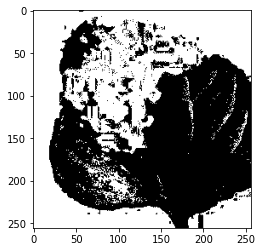

In [11]:
seg = segment_background(image)
plt.imshow(seg, cmap = 'gray', vmin = 0, vmax = 255)



<p> Not a good method for diseased images</p>

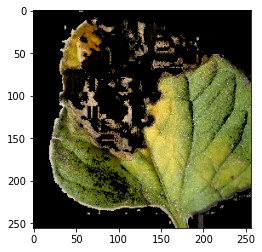

In [12]:
resImg = cv2.bitwise_and(image, image, mask = 255 - seg)
plt.imshow(resImg)

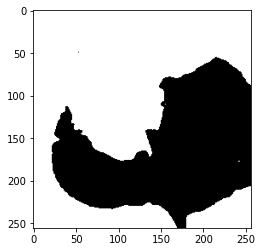

In [13]:
im = cv2.cvtColor(image, cv2.COLOR_RGB2LAB)
blur = cv2.GaussianBlur(im[:, :, 1],(5,5),0)
res, th2 = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

plt.imshow(th2, cmap = 'gray', vmin = 0, vmax = 255)

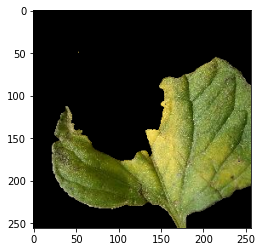

In [14]:
resImg = cv2.bitwise_and(image, image, mask = 255 - th2)
plt.imshow(resImg)

<h2> Using Kmeans Clustering</h2>

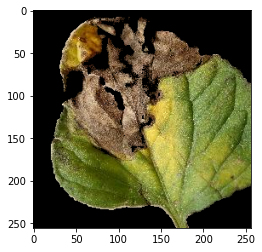

In [15]:
image2=cv2.cvtColor(image, cv2.COLOR_RGB2LAB)

l,a,b=cv2.split(image2)

l,a,b=(l.flatten(),a.flatten(),b.flatten())
#create a vector containing a*b* channel
shape=image.shape

vector=image2[:,:,1:]
vector=vector.reshape(-1,2)

#convert to float32
vector=np.float32(vector)

#criteria
criteria=(cv2.TERM_CRITERIA_EPS+cv2.TERM_CRITERIA_MAX_ITER,10,1.0)
K=4
attempts=10
ret,label,center=cv2.kmeans(vector,K,None,criteria,attempts,cv2.KMEANS_RANDOM_CENTERS)


center=np.uint8(center)
res=center[label.flatten()]

resArr=[]
for ele in res:
    a,b=ele[0],ele[1]
    resArr.append([90,a,b])
resArr=np.array(resArr,dtype=np.uint8)
resArr=resArr.reshape(shape)

# rtArr=cv2.cvtColor(resArr,cv2.COLOR_LAB2RGB)
# plt.imshow(rtArr)
a_channel=resArr[:,:,1]
b_channel=resArr[:,:,2]
# plt.imshow(b_channel,cmap="gray")
# hist,bins,_=plt.hist(a_channel.flatten(),bins=256,range=(0,256))
# plt.show()
minVal=np.amin(b_channel)

#segmenting the background from the original image
resImg=[]
#will also count total pixels
totalPixels=0

for ele1,ele2 in zip(resArr.reshape(-1,3),image.reshape(-1,3)):
    b=ele1[2]
    if b==minVal:
        resImg.append([0,0,0])
    else:
        resImg.append([ele2[0],ele2[1],ele2[2]])
resImg = np.array(resImg, dtype = np.uint8)  
resImg = resImg.reshape(image.shape)
plt.imshow(resImg)


